# Primitives

Primitive: The smallest processsing unit for a given abstraction level.   
Estimator Primitive: Computes expectation values of observables with the repective states prepared by quantum circuits.  
Samplter Primitive: Returns shot by shot bit strings sampled from the probability distribution of the quantum state prepared on device.

# Tranverse field Ising model to demo primitives

In [2]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import YGate, UnitaryGate
import numpy as np

SYGate = UnitaryGate(YGate().power(1/2), label = r'$\sqrt{Y}$')
SYdgGate = UnitaryGate(SYGate.inverse(), label = r'$\sqrt{Y}^\dag$')

def generate_1d_tfim_circuit(num_qubits, num_cl_bits, num_trotter_steps, rx_angle, trotter_barriers = False, layer_barriers = False):
    if num_cl_bits == 0: 
        qc = QuantumCircuit(num_qubits)
    else: 
        qc = QuantumCircuit(num_qubits, num_cl_bits)

    for trotter_step in range(num_trotter_steps):
        add_1d_tfim_trotter_layer(qc, rx_angle)

        if trotter_barriers: 
            qc.barrier()

    return qc

def add_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers = False):
    # for adding RZZ layes in the even layers
    for i in range(0, qc.num_qubits-1,2):
        qc.sdg([i, i+1])
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
    if layer_barriers:
        qc.barrier() 

    # for adding RZZ layes in the odd layers
    for i in range(1, qc.num_qubits-1,2):
        qc.sdg([i, i+1])
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])       
    if layer_barriers:
        qc.barrier() 

    qc.rx(rx_angle, list(range(qc.num_qubits)))    
    if layer_barriers:
        qc.barrier() 

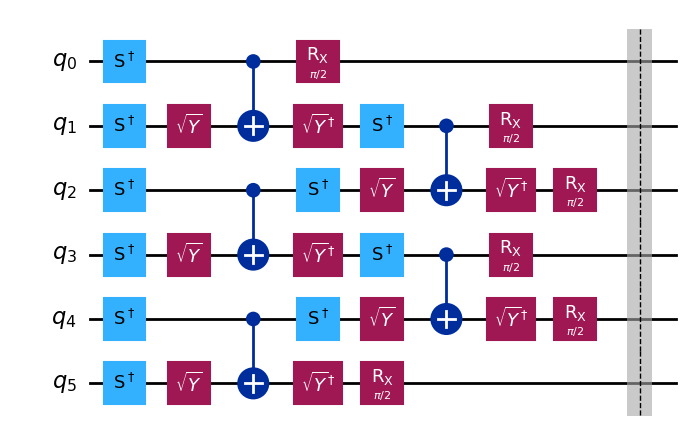

In [3]:
num_qubits = 6 
num_trotter_steps = 1
rx_angle =  0.5*np.pi

qc = generate_1d_tfim_circuit(num_qubits, num_trotter_steps = num_trotter_steps,num_cl_bits=0, rx_angle = rx_angle, trotter_barriers=True, layer_barriers=True)
qc.draw(output = 'mpl')

## Demo: Sampler

In [4]:
def append_mirrored_id_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers = False, layer_barriers = False):

    for trotter_step in range(num_trotter_steps):
        add_mirrored_1d_tfim_trotter_layer(qc, rx_angle)

        if trotter_barriers: 
            qc.barrier()

def add_mirrored_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers = False):

    qc.rx(-rx_angle, list(range(qc.num_qubits)))    
    if layer_barriers:
        qc.barrier() 

    # for adding RZZ layes in the odd layers
    for i in range(1, qc.num_qubits-1,2):
        qc.append(SYGate, [i+1])       
        qc.cx(i, i+1)
        qc.s([i, i+1])
    if layer_barriers:
        qc.barrier() 
       
    # for adding RZZ layes in the even layers
    for i in range(0, qc.num_qubits-1,2):
       qc.append(SYGate, [i+1])
       qc.cx(i, i+1)
       qc.s([i, i+1])
    if layer_barriers:
        qc.barrier() 

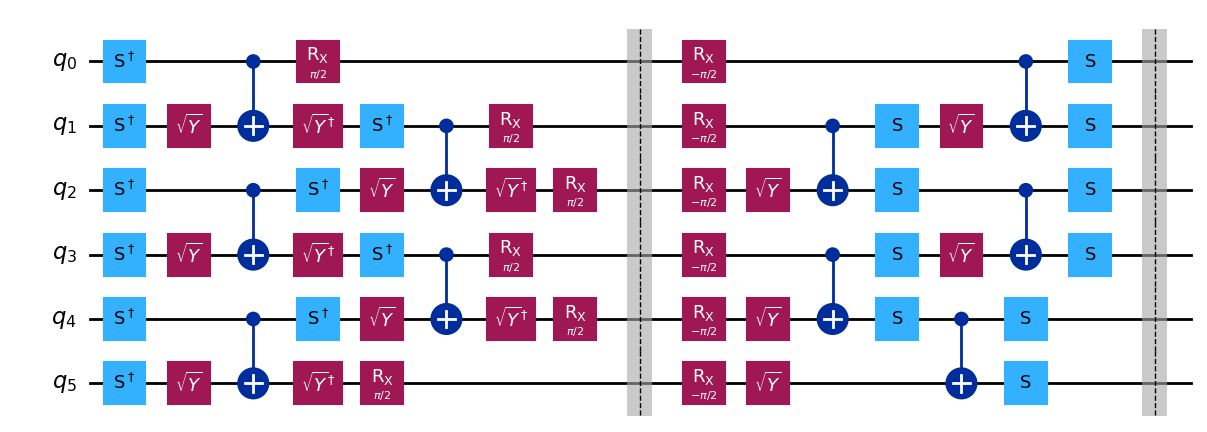

In [5]:
append_mirrored_id_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers = True, layer_barriers = True)
qc.draw(output='mpl', fold = -1)

## Step 1: Map the problem to circuits and observables

In [6]:
max_trotter_steps = 10
num_qubits = 100
measured_qubits = [49,50]
num_cl_bits = len(measured_qubits)
qc_list = []

for trotter_step in range(max_trotter_steps):
    qc = generate_1d_tfim_circuit(num_qubits, num_trotter_steps = num_trotter_steps,num_cl_bits=2, rx_angle = rx_angle, trotter_barriers=True, layer_barriers=True)
    append_mirrored_id_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers = True, layer_barriers = True)
    qc.measure(measured_qubits, list(range(len(measured_qubits))))
    qc_list.append(qc)

## Step 2: Optimise 

In [7]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService

backend = 'ibm_brisbane'
service = QiskitRuntimeService()
backend = service.get_backend(backend)

qc_transpiled_list = transpile(qc_list, backend = backend, optimization_level = 1)

## Step 3:  Execute on hardware

In [18]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend = backend)
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = 'XY4'

job = sampler.run(qc_transpiled_list)

print(job.job_id())

crvw9cx7jqmg008zn6z0


## Post-processing and plotting

In [8]:
job_id = 'crvw9cx7jqmg008zn6z0'

job = service.job(job_id)

survival_prob_list = []

for trotter_step in range(max_trotter_steps):
    try: 
        data = job.results()[trotter_step].data
        survival_prob_list.append(data.c.get_counts()['0' * len(measured_qubits)]/data.c.num_shots)
    except:
        survival_prob_list.append(0)
    


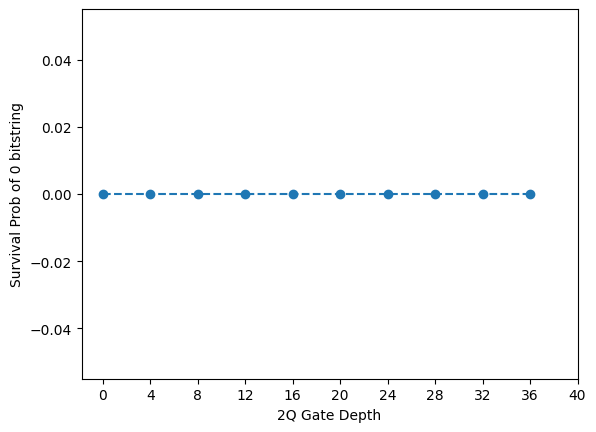

In [10]:
import matplotlib.pyplot as plt

plt.plot(list(range(0, 4 * max_trotter_steps, 4)), survival_prob_list, '--o')
plt.xlabel('2Q Gate Depth')
plt.ylabel('Survival Prob of 0 bitstring')
plt.xticks(np.arange(0,44,4))
plt.show()